In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jovian
import opendatasets as od
import matplotlib as mpl
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',50)
sns.set_style('darkgrid')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (25, 14)
mpl.rcParams['figure.facecolor'] = "#00000000"

In [3]:
df = pd.read_csv('/Users/okabe/Some Datasets/Wheather/weatherAUS.csv')

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
df.dropna(subset=['RainTomorrow'], inplace=True)

In [7]:
print('There are {} rows and {} columns in the dataset'.format(df.shape[0], df.shape[1]))

There are 142193 rows and 23 columns in the dataset


In [8]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mvbosamiya20/random-forest-tree-regressor" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/mvbosamiya20/random-forest-tree-regressor


'https://jovian.ai/mvbosamiya20/random-forest-tree-regressor'

## Training and Validation sets

In [9]:
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

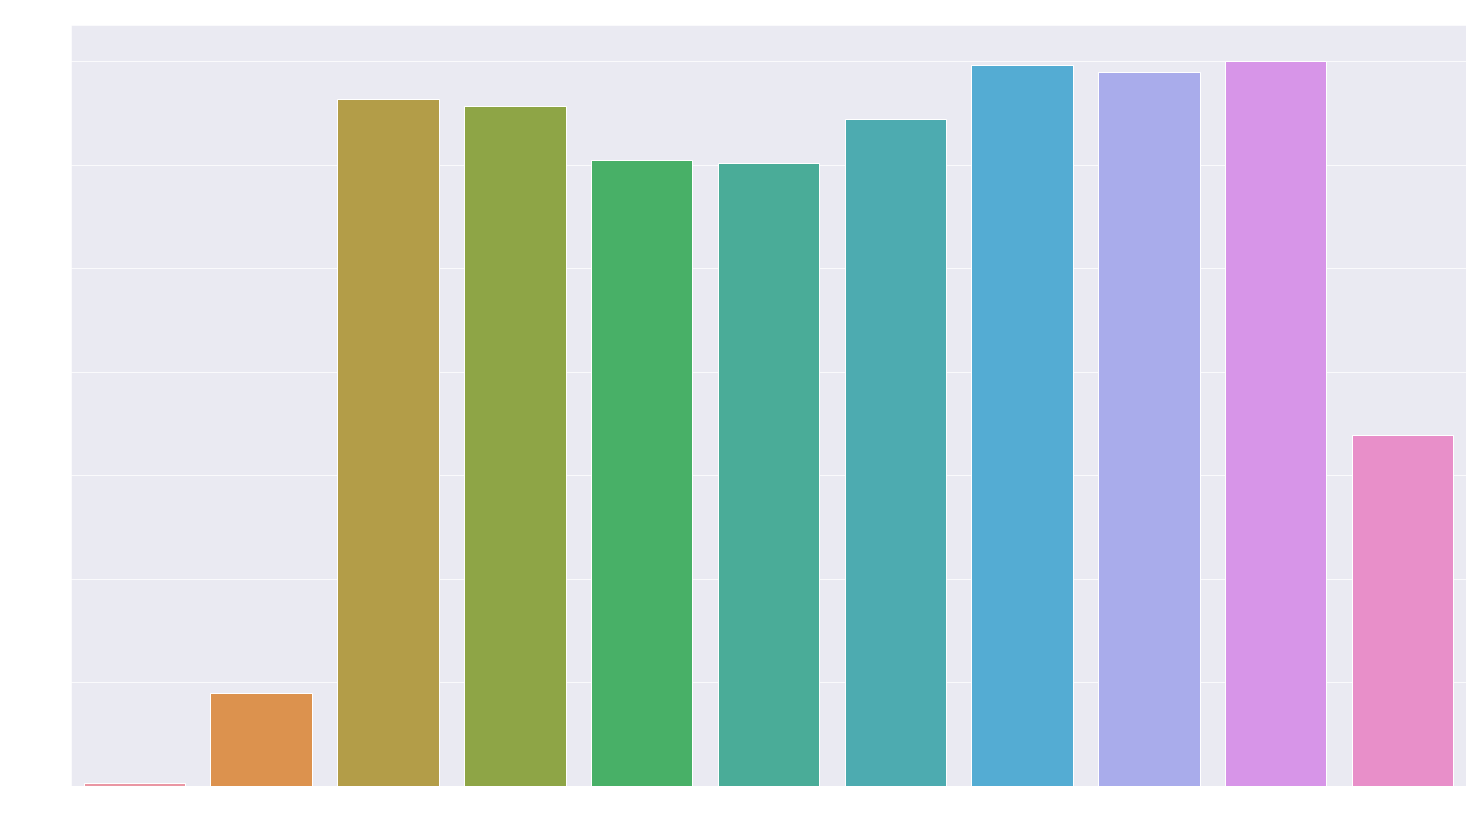

In [10]:
plt.title('Number of rows per year')
sns.countplot(x = pd.to_datetime(df.Date).dt.year);

In [11]:
year = pd.to_datetime(df.Date).dt.year

In [12]:
train_df = df[year<2015]
val_df = df[year==2015]
test_df = df[year>2015]

In [13]:
print('The shape of train_df is: ', train_df.shape)
print('The shape of val_df is: ', val_df.shape)
print('The shape of train_df is: ', test_df.shape)

The shape of train_df is:  (98988, 23)
The shape of val_df is:  (17231, 23)
The shape of train_df is:  (25974, 23)


## Input and Target columns

In [14]:
input_cols = list(df.columns)[1:-1]
target_col = 'RainTomorrow'

In [15]:
train_inputs = train_df[input_cols].copy()
train_target = train_df[target_col].copy()

In [16]:
val_inputs = val_df[input_cols].copy()
val_target = val_df[target_col].copy()

In [17]:
test_inputs = test_df[input_cols].copy()
test_target = test_df[target_col].copy()

Numeric and Categorical columns

In [18]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [19]:
print('Numeric columns are: ', numeric_cols)
print('\nCategorical columns are: ', categorical_cols)

Numeric columns are:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

Categorical columns are:  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


## Imputing the missing naN values

In [20]:
from sklearn.impute import SimpleImputer

In [21]:
imputer = SimpleImputer(strategy='mean').fit(df[numeric_cols])

In [22]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [23]:
val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,-8.2,-3.2,0.0,0.0,0.0,7.0,0.0,0.0,4.0,0.0,988.1,982.2,0.0,0.0,-6.2,-4.0
max,31.9,45.4,247.2,70.4,14.5,135.0,87.0,74.0,100.0,100.0,1039.3,1037.3,8.0,8.0,37.5,42.8


## Encoding the Data

In [24]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(df[categorical_cols])

In [26]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [27]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [28]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Training and Visualizing Decision Trees

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
model = DecisionTreeClassifier(random_state=42)

In [31]:
model.fit(X_train, train_target)

DecisionTreeClassifier(random_state=42)

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [33]:
train_preds = model.predict(X_train)

In [34]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [35]:
pd.value_counts(train_preds)

No     76707
Yes    22281
dtype: int64

In [36]:
train_probs = model.predict_proba(X_train)

In [37]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [38]:
accuracy_score(train_preds, train_target)

0.9999797955307714

In [39]:
model.score(X_val, val_target)

0.792292960362138

In [40]:
val_target.value_counts()/len(val_target)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

## Visualization

In [41]:
from sklearn.tree import plot_tree, export_text

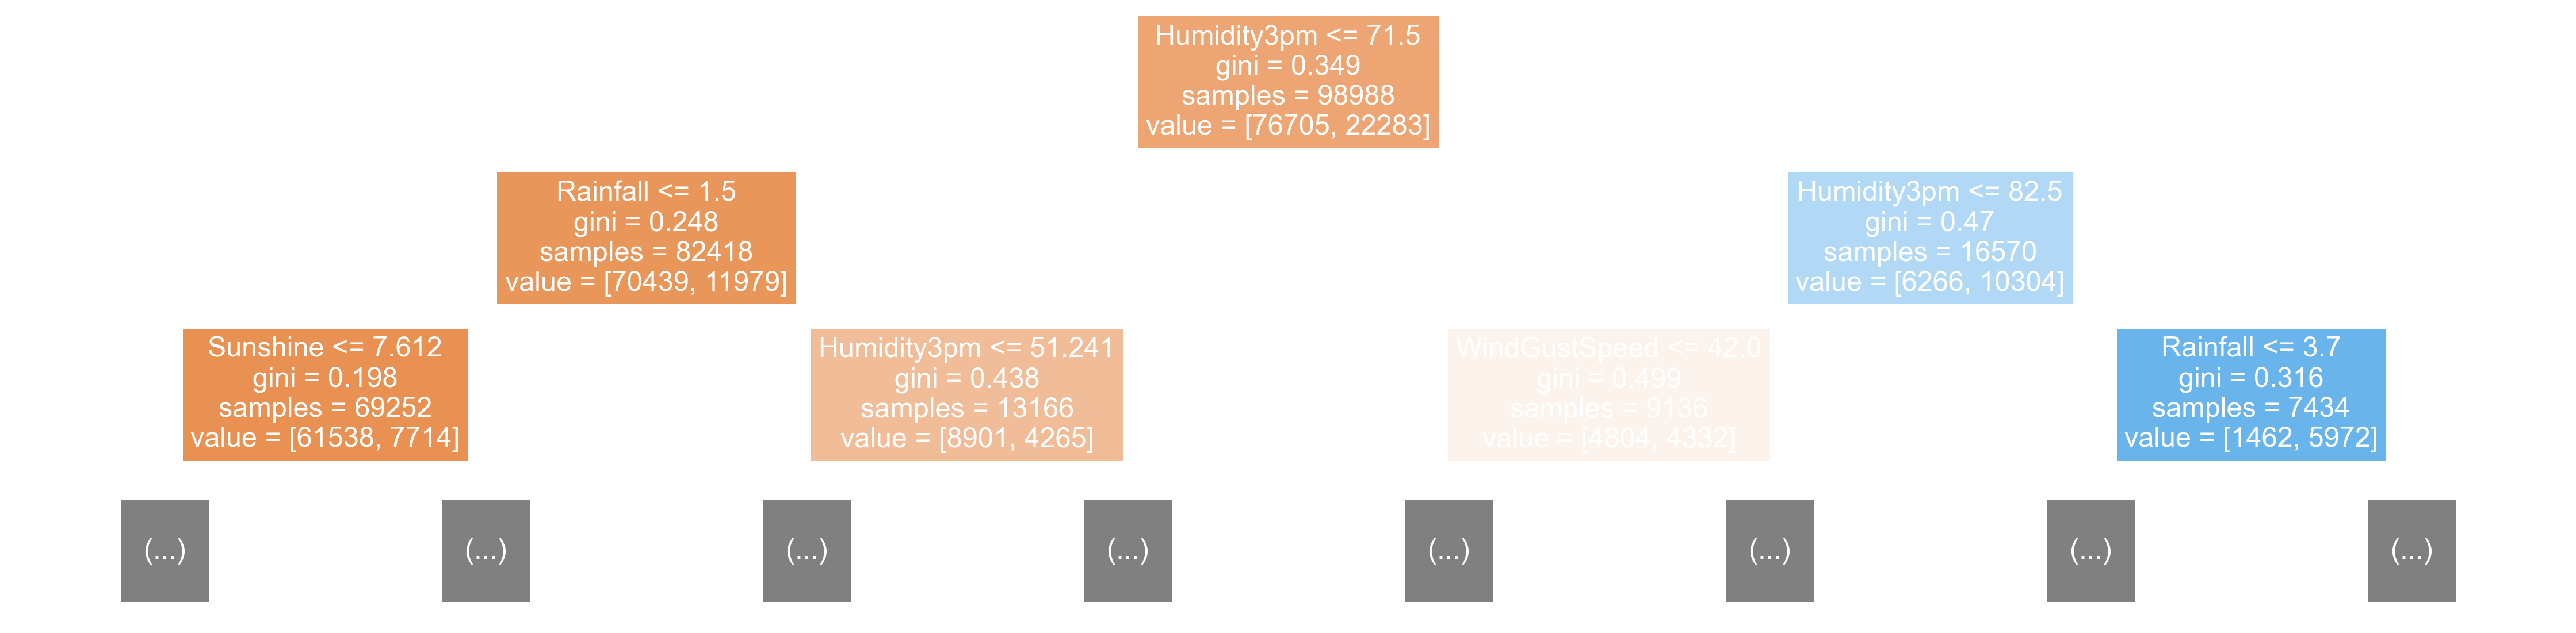

In [42]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

In [43]:
model.tree_.max_depth

48

In [44]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text)

|--- Humidity3pm <= 71.50
|   |--- Rainfall <= 1.50
|   |   |--- Sunshine <= 7.61
|   |   |   |--- Pressure3pm <= 1013.55
|   |   |   |   |--- WindGustSpeed <= 53.00
|   |   |   |   |   |--- Humidity3pm <= 27.50
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 7.50
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 6.50
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 1005.75
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  1005.75
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  6.50
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 5.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  5.20
|   |   |   |   |   |   |   |   |   |   |   |-

## Feature Importance

In [45]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [46]:
importance_df = pd.DataFrame({
    'feature':X_train.columns,
    'importance':model.feature_importances_,
}, index=None).sort_values('importance', ascending=False)

In [47]:
importance_df.head()

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465


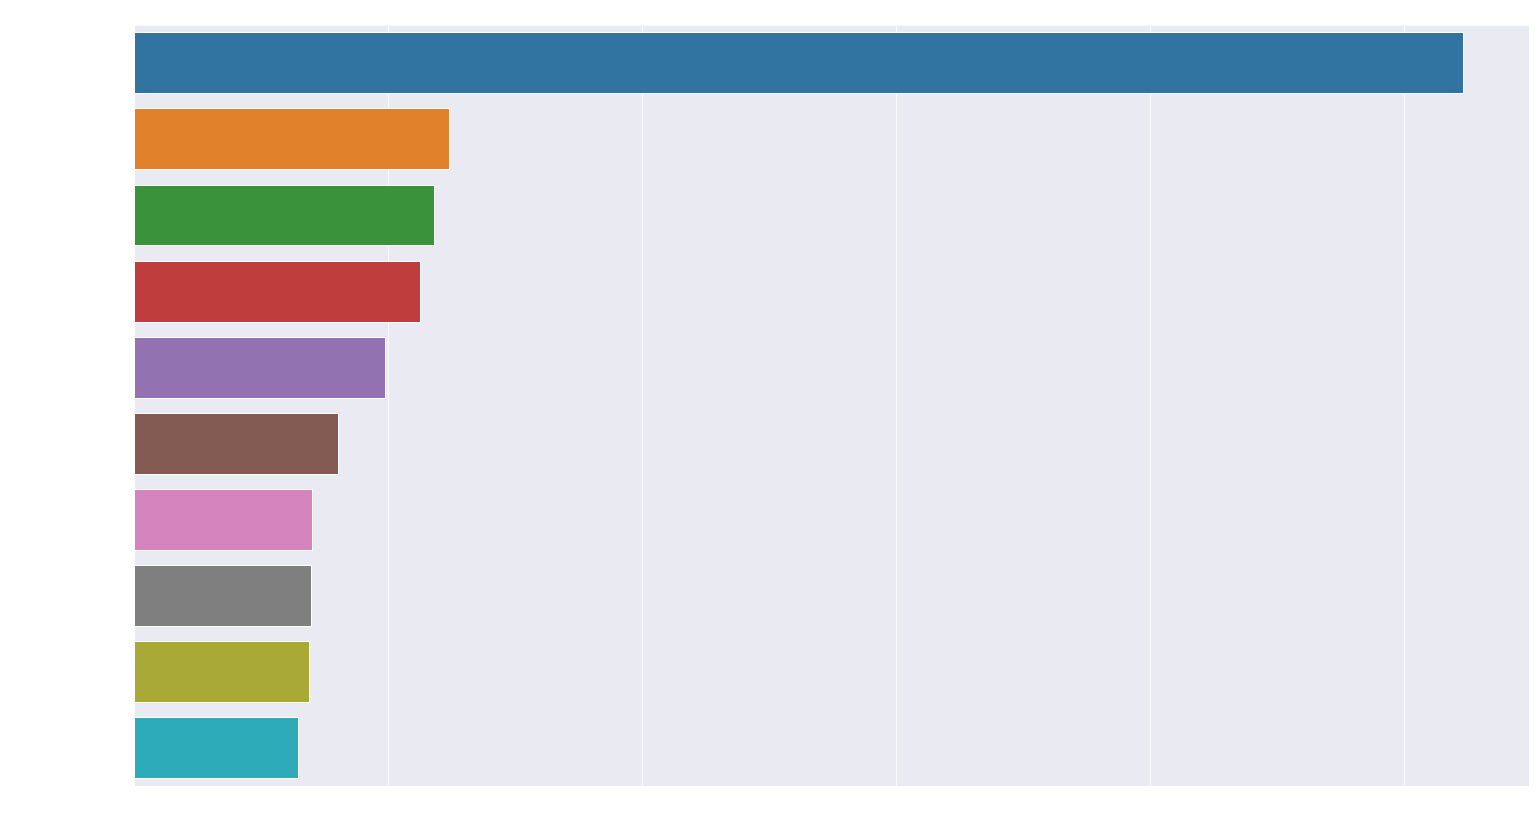

In [48]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [49]:
?DecisionTreeClassifier

In [88]:
model = DecisionTreeClassifier(max_depth=4, random_state=42)

In [89]:
model.fit(X_train, train_target)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [90]:
model.score(X_train, train_target)

0.8342930456216915

In [91]:
model.score(X_val, val_target)

0.8356450583251117

In [92]:
model.classes_

array(['No', 'Yes'], dtype=object)

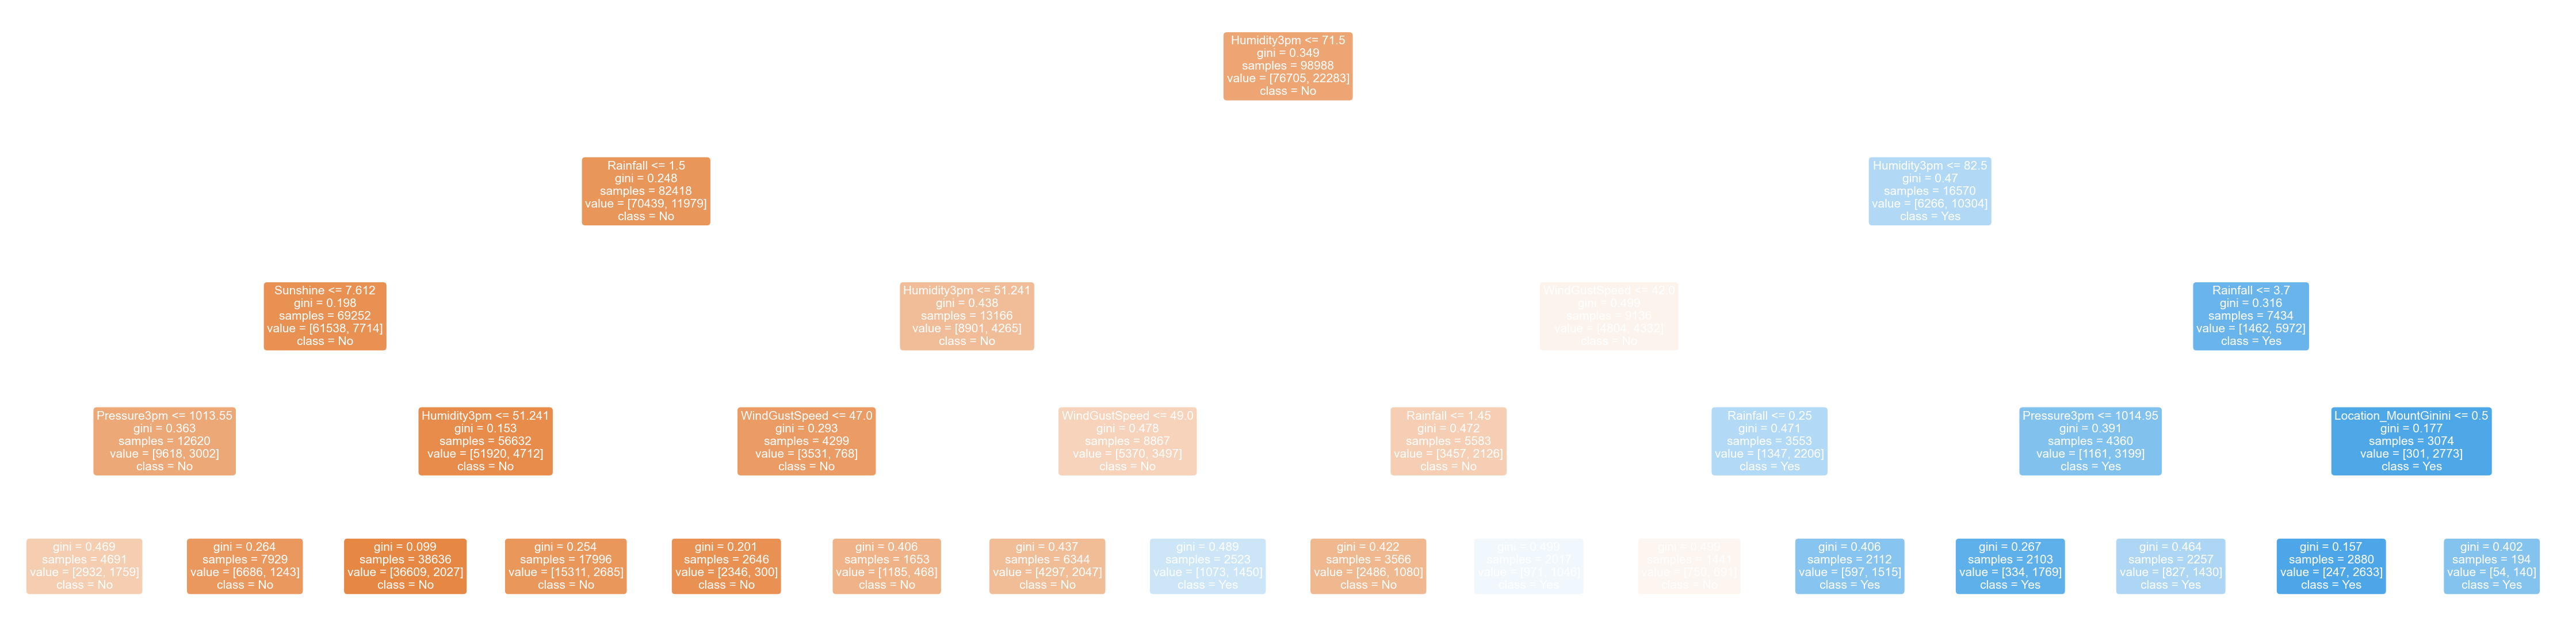

In [94]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [95]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 71.50
|   |--- Rainfall <= 1.50
|   |   |--- Sunshine <= 7.61
|   |   |   |--- Pressure3pm <= 1013.55
|   |   |   |   |--- class: No
|   |   |   |--- Pressure3pm >  1013.55
|   |   |   |   |--- class: No
|   |   |--- Sunshine >  7.61
|   |   |   |--- Humidity3pm <= 51.24
|   |   |   |   |--- class: No
|   |   |   |--- Humidity3pm >  51.24
|   |   |   |   |--- class: No
|   |--- Rainfall >  1.50
|   |   |--- Humidity3pm <= 51.24
|   |   |   |--- WindGustSpeed <= 47.00
|   |   |   |   |--- class: No
|   |   |   |--- WindGustSpeed >  47.00
|   |   |   |   |--- class: No
|   |   |--- Humidity3pm >  51.24
|   |   |   |--- WindGustSpeed <= 49.00
|   |   |   |   |--- class: No
|   |   |   |--- WindGustSpeed >  49.00
|   |   |   |   |--- class: Yes
|--- Humidity3pm >  71.50
|   |--- Humidity3pm <= 82.50
|   |   |--- WindGustSpeed <= 42.00
|   |   |   |--- Rainfall <= 1.45
|   |   |   |   |--- class: No
|   |   |   |--- Rainfall >  1.45
|   |   |   |   |--- class: Yes
|   | 

In [99]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_target)
    train_error = 1 - model.score(X_train, train_target)
    val_error = 1 - model.score(X_val, val_target)
    return {'Max Depth ':md, 'Training Error': train_error, 'Validation Error': val_error}

In [100]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])

Wall time: 42.1 s


In [101]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157449


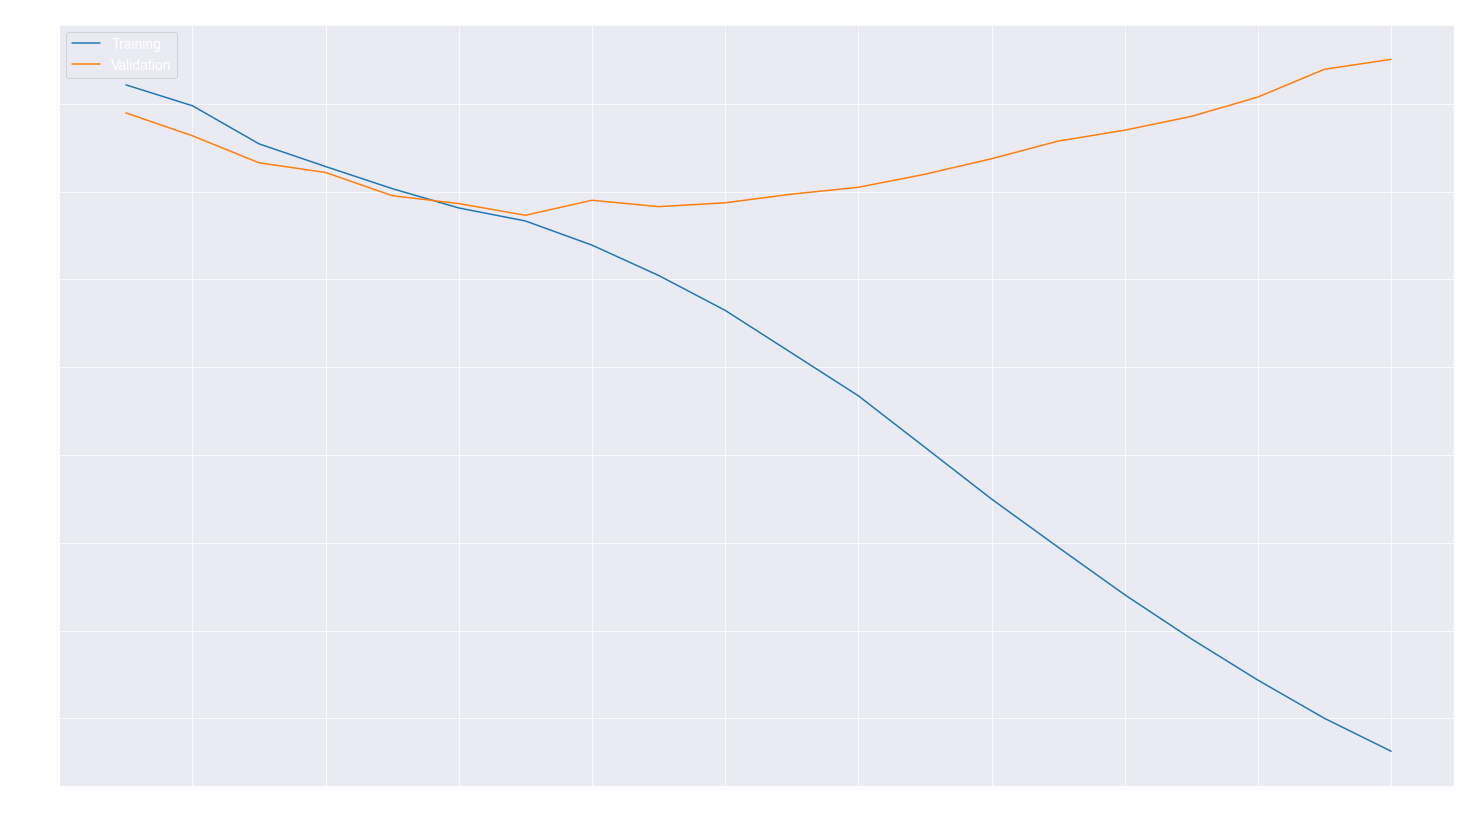

In [105]:
plt.figure()
plt.plot(errors_df['Max Depth '], errors_df['Training Error'])
plt.plot(errors_df['Max Depth '], errors_df['Validation Error'])
plt.title('Training error vs Validation Error')
plt.xticks(range(0, 21, 2))
plt.xlabel('Max Depth ')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [106]:
model = DecisionTreeClassifier(max_depth=7, random_state=42)

In [107]:
model.fit(X_train, train_target)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [108]:
model.score(X_val, val_target)

0.8453949277465034

In [114]:
model = DecisionTreeClassifier(max_leaf_nodes=140, random_state=42)

In [115]:
model.fit(X_train, train_target)

DecisionTreeClassifier(max_leaf_nodes=140, random_state=42)

In [116]:
model.score(X_train, train_target)

0.848880672404736

In [117]:
model.score(X_val, val_target)

0.8443502988799257

In [118]:
model.tree_.max_depth

12

In [120]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 71.50
|   |--- Rainfall <= 1.50
|   |   |--- Sunshine <= 7.61
|   |   |   |--- Pressure3pm <= 1013.55
|   |   |   |   |--- WindGustSpeed <= 53.00
|   |   |   |   |   |--- Humidity3pm <= 27.50
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  27.50
|   |   |   |   |   |   |--- Sunshine <= 0.75
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.75
|   |   |   |   |   |   |   |--- Pressure3pm <= 1004.15
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  1004.15
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 57.50
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   